In [1]:
!pip install torch
!pip install tqdm
!pip install torchvision
!pip install pretrainedmodels
!pip install cuda
!pip install torch

     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d1d2bda0c2ada350c1657e6bf5c75c8e5fa6122738ef1633d12e18a92325ee1f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda


In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
from tqdm import tqdm
import torchvision
import pretrainedmodels
import torch
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
import torch.nn.functional as F

In [11]:
#config

out_count=117
# constant paths
# learning parameters
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1
# show dataset keypoint plot
SHOW_DATASET_PLOT = False
drive.mount('/content/drive')
id="/content/drive/MyDrive/"
ROOT_PATH = id#../input'
OUTPUT_PATH = id#../outputs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class our_model(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(our_model, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
            #for layer in self.model.layers:
              #layer.trainable=False
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)

        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, out_count)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0
    

In [5]:
def train_test_split(csv_path, split):
    df_data = pd.read_csv(id+"training/cows/Cow_poses_2.csv")
    len_data = len(df_data)
    # calculate the validation data sample length
    valid_split = int(len_data * split)
    # calculate the training data samples length
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    return training_samples, valid_samples
import random
img=[]
kk=[]
for i in range(1):

        f=open(id+"training/cows/Cow_poses_2.csv", 'r')
        count=0
        for ss in f:
            s=ss
            print(s)
            if(True):
                s1 = s[(s.find(";")) + 1:]
                s = s[0:(s.find(";"))]
                s=s[1:]
                s = id+"training/cows/" + s

                image = s
                image = cv2.imread(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                orig_h, orig_w, channel = image.shape
                size=224
                image = cv2.resize(image, (size, size))
                image = image / 255.0
                # transpose for getting the channel size to index 0
                image = np.transpose(image, (2, 0, 1))
                img.append(image)
                #       cv2.imshow("1", image)
                #        key=cv2.waitKey(27)

                k = []

                c = 0
                i = 0
                k=s1.split(';')
                k.pop()
                for i in range(len(k)):
                  k[i]=float(k[i])
                  if(i%3==1):
                      k[i]=float(k[i])/1024

                  if(i%3==2):
                      k[i]=float(k[i])/683
                
                kk.append(k)



class FaceKeypointDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tmp=random.randint(0, len(kk)-1)

        return {
            'image': torch.tensor(img[tmp], dtype=torch.float),
            'keypoints': torch.tensor(kk[tmp], dtype=torch.float),
        }


# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{ROOT_PATH}/training/cows/Cow_poses_2.csv",
                                                   TEST_SPLIT)

#print(training_samples, "/training")
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(training_samples,
                                 "/training")
valid_data = FaceKeypointDataset(valid_samples,
                                 "/training")
# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False)
valid_loader = DataLoader(valid_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False)
print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")


"cow_10001.jpg;0;0;0;0;0;0;1;534.0;332.6666666666667;1;604.4052863436124;672.7885462555066;1;525.5555555555555;472.2222222222222;1;490.7488986784141;672.7885462555066;1;510.44444444444446;241.1111111111111;1;553.5555555555555;314.0;0;0;0;1;514.4444444444445;452.22222222222223;1;461.1111111111111;450.8888888888889;1;489.1111111111111;457.1111111111111;1;797.5555555555555;210.0;0;0;0;1;504.6666666666667;602.8888888888889;1;582.8888888888889;213.1111111111111;0;0;0;1;803.3333333333334;540.6666666666666;1;488.6666666666667;450.8888888888889;1;427.3333333333333;321.1111111111111;1;542.0;518.4444444444445;0;0;0;1;439.77777777777777;335.3333333333333;0;0;0;1;378.44444444444446;318.44444444444446;1;1019.7777777777778;221.1111111111111;0;0;0;1;634.8888888888889;523.7777777777778;1;609.5555555555555;604.2222222222222;1;598.8888888888889;320.22222222222223;0;0;0;1;979.7777777777778;527.7777777777778;1;815.7777777777778;371.77777777777777;0;0;0;1;486.0;438.0;1;563.3333333333334;219.33333333333331;

In [6]:



def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    output_keypoint = output_keypoint.reshape(-1, 3)
    orig_keypoint = orig_keypoint.reshape(-1, 3)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.close()


def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact corrent and the faces align wiht the keypoint features. The plot
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()


    

Training intermediate layer parameters...
cuda
Epoch 1 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0832
Val Loss: 0.0637
Epoch 2 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0663
Val Loss: 0.0500
Epoch 3 of 300


32it [00:07,  4.29it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0630
Val Loss: 0.1607
Epoch 4 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  5.47it/s]                       


Train Loss: 0.0633
Val Loss: 0.0491
Epoch 5 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:01,  3.88it/s]                       


Train Loss: 0.0594
Val Loss: 0.0582
Epoch 6 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.27it/s]                       


Train Loss: 0.0587
Val Loss: 0.0575
Epoch 7 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.23it/s]                       


Train Loss: 0.0575
Val Loss: 0.0512
Epoch 8 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.29it/s]                       


Train Loss: 0.0553
Val Loss: 0.0613
Epoch 9 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.43it/s]                       


Train Loss: 0.0558
Val Loss: 0.0473
Epoch 10 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.80it/s]                       


Train Loss: 0.0546
Val Loss: 0.0514
Epoch 11 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0530
Val Loss: 0.0487
Epoch 12 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0550
Val Loss: 0.0494
Epoch 13 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  6.02it/s]                       


Train Loss: 0.0588
Val Loss: 0.0752
Epoch 14 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0565
Val Loss: 0.0564
Epoch 15 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.59it/s]                       


Train Loss: 0.0566
Val Loss: 0.0777
Epoch 16 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0553
Val Loss: 0.0523
Epoch 17 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.24it/s]                       


Train Loss: 0.0565
Val Loss: 0.0571
Epoch 18 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.59it/s]                       


Train Loss: 0.0577
Val Loss: 0.0650
Epoch 19 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.71it/s]                       


Train Loss: 0.0539
Val Loss: 0.0615
Epoch 20 of 300


32it [00:07,  4.36it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0574
Val Loss: 0.1295
Epoch 21 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0571
Val Loss: 0.1084
Epoch 22 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.78it/s]                       


Train Loss: 0.0540
Val Loss: 0.0496
Epoch 23 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  5.98it/s]                       


Train Loss: 0.0542
Val Loss: 0.0490
Epoch 24 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0571
Val Loss: 0.0853
Epoch 25 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.85it/s]                       


Train Loss: 0.0564
Val Loss: 0.0541
Epoch 26 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0549
Val Loss: 0.0556
Epoch 27 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0533
Val Loss: 0.0737
Epoch 28 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.73it/s]                       


Train Loss: 0.0545
Val Loss: 0.0498
Epoch 29 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.80it/s]                       


Train Loss: 0.0529
Val Loss: 0.0575
Epoch 30 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0520
Val Loss: 0.0579
Epoch 31 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.79it/s]                       


Train Loss: 0.0527
Val Loss: 0.0551
Epoch 32 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0514
Val Loss: 0.0486
Epoch 33 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0524
Val Loss: 0.0551
Epoch 34 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  5.14it/s]                       


Train Loss: 0.0527
Val Loss: 0.0511
Epoch 35 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0492
Val Loss: 0.0486
Epoch 36 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0566
Val Loss: 0.0959
Epoch 37 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.76it/s]                       


Train Loss: 0.0551
Val Loss: 0.0557
Epoch 38 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.49it/s]                       


Train Loss: 0.0536
Val Loss: 0.0506
Epoch 39 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0492
Val Loss: 0.0504
Epoch 40 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0516
Val Loss: 0.0542
Epoch 41 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.87it/s]                       


Train Loss: 0.0545
Val Loss: 0.0594
Epoch 42 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.73it/s]                       


Train Loss: 0.0524
Val Loss: 0.0553
Epoch 43 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.62it/s]                       


Train Loss: 0.0513
Val Loss: 0.0591
Epoch 44 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.71it/s]                       


Train Loss: 0.0513
Val Loss: 0.0537
Epoch 45 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.59it/s]                       


Train Loss: 0.0513
Val Loss: 0.0507
Epoch 46 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.60it/s]                       


Train Loss: 0.0484
Val Loss: 0.0505
Epoch 47 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.49it/s]                       


Train Loss: 0.0504
Val Loss: 0.0541
Epoch 48 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0460
Val Loss: 0.0509
Epoch 49 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  4.93it/s]                       


Train Loss: 0.0476
Val Loss: 0.0490
Epoch 50 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0516
Val Loss: 0.0451
Epoch 51 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0460
Val Loss: 0.0464
Epoch 52 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0469
Val Loss: 0.0468
Epoch 53 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.07it/s]                       


Train Loss: 0.0464
Val Loss: 0.0412
Epoch 54 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.43it/s]                       


Train Loss: 0.0447
Val Loss: 0.0459
Epoch 55 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0460
Val Loss: 0.0398
Epoch 56 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.63it/s]                       


Train Loss: 0.0518
Val Loss: 0.0570
Epoch 57 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0515
Val Loss: 0.0493
Epoch 58 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0494
Val Loss: 0.0459
Epoch 59 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.81it/s]                       


Train Loss: 0.0459
Val Loss: 0.0478
Epoch 60 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.41it/s]                       


Train Loss: 0.0443
Val Loss: 0.0428
Epoch 61 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.36it/s]                       


Train Loss: 0.0452
Val Loss: 0.0414
Epoch 62 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.67it/s]                       


Train Loss: 0.0434
Val Loss: 0.0428
Epoch 63 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.47it/s]                       


Train Loss: 0.0429
Val Loss: 0.0404
Epoch 64 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.76it/s]                       


Train Loss: 0.0444
Val Loss: 0.0460
Epoch 65 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.56it/s]                       


Train Loss: 0.0434
Val Loss: 0.0422
Epoch 66 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  4.61it/s]                       


Train Loss: 0.0412
Val Loss: 0.0391
Epoch 67 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0429
Val Loss: 0.0729
Epoch 68 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0445
Val Loss: 0.0397
Epoch 69 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.33it/s]                       


Train Loss: 0.0423
Val Loss: 0.0530
Epoch 70 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.71it/s]                       


Train Loss: 0.0490
Val Loss: 0.0481
Epoch 71 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.34it/s]                       


Train Loss: 0.0501
Val Loss: 0.0525
Epoch 72 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.72it/s]                       


Train Loss: 0.0476
Val Loss: 0.0416
Epoch 73 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.70it/s]                       


Train Loss: 0.0486
Val Loss: 0.0718
Epoch 74 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0452
Val Loss: 0.0414
Epoch 75 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0456
Val Loss: 0.0434
Epoch 76 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.39it/s]                       


Train Loss: 0.0450
Val Loss: 0.0433
Epoch 77 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0441
Val Loss: 0.0659
Epoch 78 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.83it/s]                       


Train Loss: 0.0445
Val Loss: 0.0324
Epoch 79 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0419
Val Loss: 0.0384
Epoch 80 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0440
Val Loss: 0.0457
Epoch 81 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0412
Val Loss: 0.0865
Epoch 82 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  6.32it/s]                       


Train Loss: 0.0437
Val Loss: 0.0389
Epoch 83 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.26it/s]                       


Train Loss: 0.0404
Val Loss: 0.0470
Epoch 84 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.45it/s]                       


Train Loss: 0.0403
Val Loss: 0.0355
Epoch 85 of 300


32it [00:07,  4.35it/s]


Validating


4it [00:00,  7.75it/s]                       


Train Loss: 0.0384
Val Loss: 0.0358
Epoch 86 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0393
Val Loss: 0.0416
Epoch 87 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0380
Val Loss: 0.0404
Epoch 88 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  4.02it/s]                       


Train Loss: 0.0369
Val Loss: 0.0368
Epoch 89 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.58it/s]                       


Train Loss: 0.0389
Val Loss: 0.0310
Epoch 90 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.29it/s]                       


Train Loss: 0.0370
Val Loss: 0.0316
Epoch 91 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0370
Val Loss: 0.0322
Epoch 92 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.34it/s]                       


Train Loss: 0.0348
Val Loss: 0.0344
Epoch 93 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.56it/s]                       


Train Loss: 0.0337
Val Loss: 0.0267
Epoch 94 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0348
Val Loss: 0.0324
Epoch 95 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.11it/s]                       


Train Loss: 0.0323
Val Loss: 0.0345
Epoch 96 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.32it/s]                       


Train Loss: 0.0322
Val Loss: 0.0255
Epoch 97 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.76it/s]                       


Train Loss: 0.0325
Val Loss: 0.0284
Epoch 98 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.34it/s]                       


Train Loss: 0.0308
Val Loss: 0.0384
Epoch 99 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.39it/s]                       


Train Loss: 0.0303
Val Loss: 0.0310
Epoch 100 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0275
Val Loss: 0.0236
Epoch 101 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0290
Val Loss: 0.0247
Epoch 102 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0272
Val Loss: 0.0242
Epoch 103 of 300


32it [00:07,  4.26it/s]


Validating


4it [00:00,  7.43it/s]                       


Train Loss: 0.0258
Val Loss: 0.0219
Epoch 104 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.64it/s]                       


Train Loss: 0.0258
Val Loss: 0.0266
Epoch 105 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0283
Val Loss: 0.0343
Epoch 106 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0266
Val Loss: 0.0226
Epoch 107 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0257
Val Loss: 0.0255
Epoch 108 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0250
Val Loss: 0.0196
Epoch 109 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  6.95it/s]                       


Train Loss: 0.0235
Val Loss: 0.0193
Epoch 110 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.27it/s]                       


Train Loss: 0.0233
Val Loss: 0.0250
Epoch 111 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.08it/s]                       


Train Loss: 0.0267
Val Loss: 0.0185
Epoch 112 of 300


32it [00:07,  4.34it/s]


Validating


4it [00:00,  7.61it/s]                       


Train Loss: 0.0260
Val Loss: 0.0217
Epoch 113 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0224
Val Loss: 0.0231
Epoch 114 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.09it/s]                       


Train Loss: 0.0223
Val Loss: 0.0159
Epoch 115 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:01,  3.63it/s]                       


Train Loss: 0.0204
Val Loss: 0.0205
Epoch 116 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0202
Val Loss: 0.0207
Epoch 117 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.58it/s]                       


Train Loss: 0.0209
Val Loss: 0.0150
Epoch 118 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0173
Val Loss: 0.0152
Epoch 119 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0169
Val Loss: 0.0146
Epoch 120 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0193
Val Loss: 0.0173
Epoch 121 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.06it/s]                       


Train Loss: 0.0256
Val Loss: 0.0265
Epoch 122 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0246
Val Loss: 0.0407
Epoch 123 of 300


32it [00:07,  4.29it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0255
Val Loss: 0.0325
Epoch 124 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.41it/s]                       


Train Loss: 0.0392
Val Loss: 0.0434
Epoch 125 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0332
Val Loss: 0.0324
Epoch 126 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0287
Val Loss: 0.0212
Epoch 127 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.41it/s]                       


Train Loss: 0.0227
Val Loss: 0.0238
Epoch 128 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.47it/s]                       


Train Loss: 0.0233
Val Loss: 0.0184
Epoch 129 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.25it/s]                       


Train Loss: 0.0201
Val Loss: 0.0146
Epoch 130 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0163
Val Loss: 0.0151
Epoch 131 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0165
Val Loss: 0.0128
Epoch 132 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.39it/s]                       


Train Loss: 0.0157
Val Loss: 0.0120
Epoch 133 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.25it/s]                       


Train Loss: 0.0152
Val Loss: 0.0109
Epoch 134 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.34it/s]                       


Train Loss: 0.0136
Val Loss: 0.0137
Epoch 135 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.35it/s]                       


Train Loss: 0.0123
Val Loss: 0.0116
Epoch 136 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.33it/s]                       


Train Loss: 0.0131
Val Loss: 0.0089
Epoch 137 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0127
Val Loss: 0.0103
Epoch 138 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0136
Val Loss: 0.0147
Epoch 139 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0362
Val Loss: 0.0285
Epoch 140 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0257
Val Loss: 0.0199
Epoch 141 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.44it/s]                       


Train Loss: 0.0199
Val Loss: 0.0136
Epoch 142 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.17it/s]                       


Train Loss: 0.0171
Val Loss: 0.0162
Epoch 143 of 300


32it [00:07,  4.23it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0145
Val Loss: 0.0119
Epoch 144 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.06it/s]                       


Train Loss: 0.0137
Val Loss: 0.0100
Epoch 145 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.06it/s]                       


Train Loss: 0.0120
Val Loss: 0.0091
Epoch 146 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.19it/s]                       


Train Loss: 0.0109
Val Loss: 0.0078
Epoch 147 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.10it/s]                       


Train Loss: 0.0109
Val Loss: 0.0083
Epoch 148 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0100
Val Loss: 0.0078
Epoch 149 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:01,  3.23it/s]                       


Train Loss: 0.0092
Val Loss: 0.0071
Epoch 150 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0096
Val Loss: 0.0066
Epoch 151 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.35it/s]                       


Train Loss: 0.0093
Val Loss: 0.0070
Epoch 152 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.60it/s]                       


Train Loss: 0.0080
Val Loss: 0.0058
Epoch 153 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.22it/s]                       


Train Loss: 0.0073
Val Loss: 0.0053
Epoch 154 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0080
Val Loss: 0.0058
Epoch 155 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0090
Val Loss: 0.0067
Epoch 156 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0073
Val Loss: 0.0061
Epoch 157 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0073
Val Loss: 0.0054
Epoch 158 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.83it/s]                       


Train Loss: 0.0073
Val Loss: 0.0057
Epoch 159 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.34it/s]                       


Train Loss: 0.0061
Val Loss: 0.0046
Epoch 160 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.36it/s]                       


Train Loss: 0.0067
Val Loss: 0.0049
Epoch 161 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0059
Val Loss: 0.0032
Epoch 162 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0059
Val Loss: 0.0048
Epoch 163 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0057
Val Loss: 0.0047
Epoch 164 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.63it/s]                       


Train Loss: 0.0056
Val Loss: 0.0046
Epoch 165 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  6.75it/s]                       


Train Loss: 0.0052
Val Loss: 0.0043
Epoch 166 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.64it/s]                       


Train Loss: 0.0054
Val Loss: 0.0037
Epoch 167 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.45it/s]                       


Train Loss: 0.0056
Val Loss: 0.0049
Epoch 168 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.44it/s]                       


Train Loss: 0.0051
Val Loss: 0.0034
Epoch 169 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.29it/s]                       


Train Loss: 0.0050
Val Loss: 0.0032
Epoch 170 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0049
Val Loss: 0.0039
Epoch 171 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0045
Val Loss: 0.0030
Epoch 172 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.60it/s]                       


Train Loss: 0.0041
Val Loss: 0.0026
Epoch 173 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.08it/s]                       


Train Loss: 0.0041
Val Loss: 0.0034
Epoch 174 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0039
Val Loss: 0.0022
Epoch 175 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.07it/s]                       


Train Loss: 0.0037
Val Loss: 0.0029
Epoch 176 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0041
Val Loss: 0.0029
Epoch 177 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.00it/s]                       


Train Loss: 0.0038
Val Loss: 0.0025
Epoch 178 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0036
Val Loss: 0.0027
Epoch 179 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0039
Val Loss: 0.0032
Epoch 180 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0038
Val Loss: 0.0030
Epoch 181 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0036
Val Loss: 0.0025
Epoch 182 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  6.61it/s]                       


Train Loss: 0.0035
Val Loss: 0.0023
Epoch 183 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.68it/s]                       


Train Loss: 0.0031
Val Loss: 0.0026
Epoch 184 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0032
Val Loss: 0.0018
Epoch 185 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.43it/s]                       


Train Loss: 0.0030
Val Loss: 0.0021
Epoch 186 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.26it/s]                       


Train Loss: 0.0031
Val Loss: 0.0018
Epoch 187 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0030
Val Loss: 0.0024
Epoch 188 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0028
Val Loss: 0.0020
Epoch 189 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.61it/s]                       


Train Loss: 0.0031
Val Loss: 0.0019
Epoch 190 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.63it/s]                       


Train Loss: 0.0031
Val Loss: 0.0018
Epoch 191 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:01,  2.91it/s]                       


Train Loss: 0.0027
Val Loss: 0.0019
Epoch 192 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.32it/s]                       


Train Loss: 0.0030
Val Loss: 0.0026
Epoch 193 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.73it/s]                       


Train Loss: 0.0035
Val Loss: 0.0024
Epoch 194 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.62it/s]                       


Train Loss: 0.0032
Val Loss: 0.0021
Epoch 195 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0031
Val Loss: 0.0021
Epoch 196 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.64it/s]                       


Train Loss: 0.0030
Val Loss: 0.0016
Epoch 197 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.58it/s]                       


Train Loss: 0.0030
Val Loss: 0.0023
Epoch 198 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.24it/s]                       


Train Loss: 0.0027
Val Loss: 0.0021
Epoch 199 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.58it/s]                       


Train Loss: 0.0027
Val Loss: 0.0021
Epoch 200 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.21it/s]                       


Train Loss: 0.0066
Val Loss: 0.0074
Epoch 201 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0052
Val Loss: 0.0030
Epoch 202 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0047
Val Loss: 0.0048
Epoch 203 of 300


32it [00:07,  4.28it/s]


Validating


4it [00:00,  7.35it/s]                       


Train Loss: 0.0040
Val Loss: 0.0028
Epoch 204 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0034
Val Loss: 0.0028
Epoch 205 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0036
Val Loss: 0.0026
Epoch 206 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.98it/s]                       


Train Loss: 0.0029
Val Loss: 0.0028
Epoch 207 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0033
Val Loss: 0.0028
Epoch 208 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0030
Val Loss: 0.0019
Epoch 209 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.26it/s]                       


Train Loss: 0.0027
Val Loss: 0.0023
Epoch 210 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0027
Val Loss: 0.0016
Epoch 211 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.47it/s]                       


Train Loss: 0.0023
Val Loss: 0.0014
Epoch 212 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0022
Val Loss: 0.0019
Epoch 213 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.32it/s]                       


Train Loss: 0.0026
Val Loss: 0.0025
Epoch 214 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0026
Val Loss: 0.0017
Epoch 215 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.29it/s]                       


Train Loss: 0.0024
Val Loss: 0.0016
Epoch 216 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0023
Val Loss: 0.0039
Epoch 217 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.32it/s]                       


Train Loss: 0.0024
Val Loss: 0.0029
Epoch 218 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0023
Val Loss: 0.0016
Epoch 219 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.67it/s]                       


Train Loss: 0.0022
Val Loss: 0.0030
Epoch 220 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0022
Val Loss: 0.0017
Epoch 221 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.57it/s]                       


Train Loss: 0.0021
Val Loss: 0.0016
Epoch 222 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.04it/s]                       


Train Loss: 0.0021
Val Loss: 0.0022
Epoch 223 of 300


32it [00:07,  4.27it/s]


Validating


4it [00:00,  7.60it/s]                       


Train Loss: 0.0019
Val Loss: 0.0012
Epoch 224 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0019
Val Loss: 0.0023
Epoch 225 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0019
Val Loss: 0.0018
Epoch 226 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.23it/s]                       


Train Loss: 0.0019
Val Loss: 0.0018
Epoch 227 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.15it/s]                       


Train Loss: 0.0019
Val Loss: 0.0017
Epoch 228 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.35it/s]                       


Train Loss: 0.0017
Val Loss: 0.0015
Epoch 229 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.20it/s]                       


Train Loss: 0.0020
Val Loss: 0.0017
Epoch 230 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0018
Val Loss: 0.0042
Epoch 231 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.12it/s]                       


Train Loss: 0.0019
Val Loss: 0.0013
Epoch 232 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0018
Val Loss: 0.0025
Epoch 233 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.33it/s]                       


Train Loss: 0.0018
Val Loss: 0.0011
Epoch 234 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.44it/s]                       


Train Loss: 0.0017
Val Loss: 0.0017
Epoch 235 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.48it/s]                       


Train Loss: 0.0016
Val Loss: 0.0022
Epoch 236 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.47it/s]                       


Train Loss: 0.0014
Val Loss: 0.0012
Epoch 237 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0017
Val Loss: 0.0013
Epoch 238 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.50it/s]                       


Train Loss: 0.0020
Val Loss: 0.0014
Epoch 239 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.54it/s]                       


Train Loss: 0.0017
Val Loss: 0.0043
Epoch 240 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0017
Val Loss: 0.0017
Epoch 241 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0027
Val Loss: 0.0024
Epoch 242 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0026
Val Loss: 0.0026
Epoch 243 of 300


32it [00:07,  4.27it/s]


Validating


4it [00:01,  2.51it/s]                       


Train Loss: 0.0037
Val Loss: 0.0037
Epoch 244 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.65it/s]                       


Train Loss: 0.0031
Val Loss: 0.0019
Epoch 245 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0022
Val Loss: 0.0017
Epoch 246 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.47it/s]                       


Train Loss: 0.0023
Val Loss: 0.0014
Epoch 247 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.15it/s]                       


Train Loss: 0.0021
Val Loss: 0.0038
Epoch 248 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.09it/s]                       


Train Loss: 0.0020
Val Loss: 0.0017
Epoch 249 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.73it/s]                       


Train Loss: 0.0019
Val Loss: 0.0017
Epoch 250 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.56it/s]                       


Train Loss: 0.0021
Val Loss: 0.0017
Epoch 251 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.30it/s]                       


Train Loss: 0.0020
Val Loss: 0.0019
Epoch 252 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0019
Val Loss: 0.0025
Epoch 253 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.40it/s]                       


Train Loss: 0.0018
Val Loss: 0.0014
Epoch 254 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.22it/s]                       


Train Loss: 0.0020
Val Loss: 0.0024
Epoch 255 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0017
Val Loss: 0.0013
Epoch 256 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.46it/s]                       


Train Loss: 0.0018
Val Loss: 0.0013
Epoch 257 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0017
Val Loss: 0.0027
Epoch 258 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.69it/s]                       


Train Loss: 0.0018
Val Loss: 0.0013
Epoch 259 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.62it/s]                       


Train Loss: 0.0015
Val Loss: 0.0012
Epoch 260 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.79it/s]                       


Train Loss: 0.0016
Val Loss: 0.0017
Epoch 261 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.27it/s]                       


Train Loss: 0.0015
Val Loss: 0.0013
Epoch 262 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.07it/s]                       


Train Loss: 0.0051
Val Loss: 0.0044
Epoch 263 of 300


32it [00:07,  4.27it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0038
Val Loss: 0.0023
Epoch 264 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0030
Val Loss: 0.0028
Epoch 265 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.43it/s]                       


Train Loss: 0.0026
Val Loss: 0.0026
Epoch 266 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0024
Val Loss: 0.0021
Epoch 267 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.28it/s]                       


Train Loss: 0.0027
Val Loss: 0.0048
Epoch 268 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0023
Val Loss: 0.0023
Epoch 269 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.66it/s]                       


Train Loss: 0.0020
Val Loss: 0.0020
Epoch 270 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.31it/s]                       


Train Loss: 0.0019
Val Loss: 0.0010
Epoch 271 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.44it/s]                       


Train Loss: 0.0028
Val Loss: 0.0023
Epoch 272 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0031
Val Loss: 0.0028
Epoch 273 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.56it/s]                       


Train Loss: 0.0025
Val Loss: 0.0031
Epoch 274 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.35it/s]                       


Train Loss: 0.0022
Val Loss: 0.0035
Epoch 275 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.42it/s]                       


Train Loss: 0.0028
Val Loss: 0.0018
Epoch 276 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0023
Val Loss: 0.0024
Epoch 277 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.23it/s]                       


Train Loss: 0.0021
Val Loss: 0.0021
Epoch 278 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.38it/s]                       


Train Loss: 0.0018
Val Loss: 0.0019
Epoch 279 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.19it/s]                       


Train Loss: 0.0017
Val Loss: 0.0019
Epoch 280 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0017
Val Loss: 0.0028
Epoch 281 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.14it/s]                       


Train Loss: 0.0060
Val Loss: 0.0053
Epoch 282 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.79it/s]                       


Train Loss: 0.0041
Val Loss: 0.0030
Epoch 283 of 300


32it [00:07,  4.26it/s]


Validating


4it [00:00,  7.71it/s]                       


Train Loss: 0.0031
Val Loss: 0.0027
Epoch 284 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.58it/s]                       


Train Loss: 0.0028
Val Loss: 0.0015
Epoch 285 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.32it/s]                       


Train Loss: 0.0023
Val Loss: 0.0016
Epoch 286 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.37it/s]                       


Train Loss: 0.0020
Val Loss: 0.0018
Epoch 287 of 300


32it [00:07,  4.33it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0019
Val Loss: 0.0020
Epoch 288 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.77it/s]                       


Train Loss: 0.0016
Val Loss: 0.0025
Epoch 289 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.17it/s]                       


Train Loss: 0.0015
Val Loss: 0.0013
Epoch 290 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.69it/s]                       


Train Loss: 0.0014
Val Loss: 0.0018
Epoch 291 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.53it/s]                       


Train Loss: 0.0013
Val Loss: 0.0013
Epoch 292 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.45it/s]                       


Train Loss: 0.0014
Val Loss: 0.0009
Epoch 293 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.29it/s]                       


Train Loss: 0.0013
Val Loss: 0.0009
Epoch 294 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.55it/s]                       


Train Loss: 0.0012
Val Loss: 0.0018
Epoch 295 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.25it/s]                       


Train Loss: 0.0012
Val Loss: 0.0012
Epoch 296 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.60it/s]                       


Train Loss: 0.0012
Val Loss: 0.0008
Epoch 297 of 300


32it [00:07,  4.31it/s]


Validating


4it [00:00,  7.49it/s]                       


Train Loss: 0.0012
Val Loss: 0.0014
Epoch 298 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.51it/s]                       


Train Loss: 0.0013
Val Loss: 0.0012
Epoch 299 of 300


32it [00:07,  4.30it/s]


Validating


4it [00:00,  7.28it/s]                       


Train Loss: 0.0014
Val Loss: 0.0019
Epoch 300 of 300


32it [00:07,  4.32it/s]


Validating


4it [00:00,  7.52it/s]                       


Train Loss: 0.0012
Val Loss: 0.0010


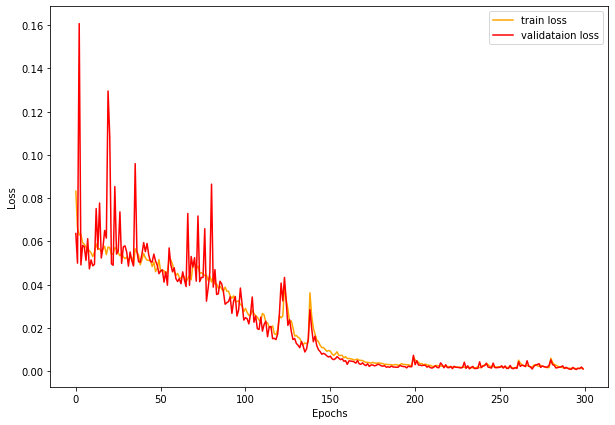

DONE TRAINING


In [12]:
model = our_model(pretrained=True, requires_grad=True).to(DEVICE)
print(DEVICE)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss()


# training function
def fit(model, dataloader, data):
    model.train()
    train_running_loss = 0.0
    # calculate the number of batches
    counter=0
    num_batches = int(len(data) / dataloader.batch_size)
    for i, data1 in tqdm(enumerate(dataloader), total=num_batches):
        counter+=1
        image, keypoints = data1['image'].to(DEVICE), data1['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    return train_loss


# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data) / dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs
            if (epoch + 1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)

    valid_loss = valid_running_loss / counter
    return valid_loss

train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    if (epoch>=50 and epoch%50==0):
        LR/=10
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    if(epoch%20==0):
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f"{OUTPUT_PATH}/training/model_{epoch}_1.pth")


plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"{OUTPUT_PATH}/loss_1.png")
plt.show()
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f"{OUTPUT_PATH}/training/model_1.pth")
print('DONE TRAINING')